In [1]:
from PIL import Image

png = Image.open('1.jpeg').convert('RGBA')
background = Image.new('RGBA', png.size, (255,255,255))

alpha_composite = Image.alpha_composite(background, png)
alpha_composite.save('foo.jpg', 'PNG', quality=80)

In [2]:
nen = Image.open('foo.jpg')

In [3]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np
import tensorflow.compat.v1 as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

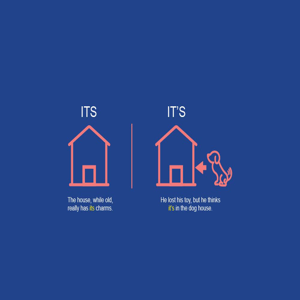

In [4]:
height = 300
width = 300

content_image_path = '1.jpeg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image.convert('RGB')

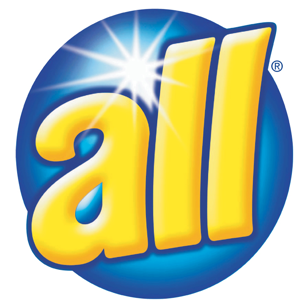

In [5]:
style_image_path = '2.png'
style_image = Image.open (style_image_path)
style_image = style_image.convert('RGB')
style_image = style_image.resize((height, width))
style_image

In [6]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 300, 300, 3)
(1, 300, 300, 3)


In [7]:
def getAverageRGB(image):
  """
  Given PIL Image, return average value of color as (r, g, b)
  """
  # no. of pixels in image
  npixels = image.size[0]*image.size[1]
  # get colors as [(cnt1, (r1, g1, b1)), ...]
  cols = image.getcolors(npixels)
  # get [(c1*r1, c1*g1, c1*g2),...]
  sumRGB = [(x[0]*x[1][0], x[0]*x[1][1], x[0]*x[1][2]) for x in cols] 
  # calculate (sum(ci*ri)/np, sum(ci*gi)/np, sum(ci*bi)/np)
  # the zip gives us [(c1*r1, c2*r2, ..), (c1*g1, c1*g2,...)...]
  avg = tuple([sum(x)/npixels for x in zip(*sumRGB)])
  return avg

In [8]:
print(getAverageRGB(style_image))
getAverageRGB(content_image)

(184.49483333333333, 192.58727777777779, 157.72943333333333)


(37.46161111111111, 68.75084444444444, 139.1671888888889)

In [9]:
content_array[:, :, :,0] -= 37.46
content_array[:, :, :, 1] -= 68.75
content_array[:, :, :, 2] -= 139.16
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 184.49
style_array[:, :, :, 1] -= 192.58
style_array[:, :, :, 2] -= 157.72
style_array = style_array[:, :, :, ::-1]

In [10]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [11]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis = 0)

The following Variables were used a Lambda layer's call (tf.concat), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 300, 300, 3) dtype=float32>
  <tf.Variable 'Variable:0' shape=(1, 300, 300, 3) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [12]:
import h5py
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [13]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [14]:
import random

content_weight = round(random.uniform(0.1, 1), 2)
style_weight = round(random.uniform(1, 10), 2)
total_variation_weight = round(random.uniform(1, 10), 2)

In [15]:
loss = backend.variable(0.)

In [16]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_image_features,
                                      combination_features)

In [17]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

In [18]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [19]:
#tf.compat.v1.disable_eager_execution()
grads = backend.gradients(loss, combination_image)

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [ ]:
outputs = [loss]
outputs = outputs + grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
     x = x.reshape((1, height, width, 3))
     outs = f_outputs([x])
     loss_value = outs[0]
     grad_values = outs[1].flatten().astype('float64')
     return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 6

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

In [ ]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)